# SOCCER GAMEPLAY VISUALIZATIONS AND ANALYSES

### IO
* Event and Tracking Data

### ANALYSES
* Expected Possession Value
* Pitch Control
* Expected Possession Value added

### VISUALIZATIONS
* Soccer field plot
* Frame of positions of players and ball plot
* EPV plot
* Pitch Control for frame plot
* Pitch Control match clip with EPV added 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
import sys
import os

In [39]:
module_path = os.path.abspath(os.path.join('..'))+'/source'

In [40]:
%load_ext autoreload
%autoreload 2

# Removing redundant Metrica from import names and .py files and m from aliases would simplify things a bit. Too much retracing for the benefit though.
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import Metrica_EPV as mepv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IO - Event and Tracking Data
* Event data containing events like `PASS`, `SHOT`, `RECOVERY` with corresponding frames.
* Tracking data containing positions of each player and the ball. 25 frames/sec.


### Load Event Data into Pandas

In [41]:
# set up initial path to data
# DATADIR = '/Users/jeromekirkpatrick/Desktop/galvanize/sample-data/data'
DATADIR = '/Users/jeromekirkpatrick/Desktop/github/soccer-gameplay-visualizations-and-analyses/data'
game_id = 2 # let's look at sample match 2

In [42]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)

### Types and Subtypes of Events

In [43]:
events['Type'].value_counts()

PASS              964
CHALLENGE         311
RECOVERY          248
BALL LOST         233
SET PIECE          80
BALL OUT           49
SHOT               24
FAULT RECEIVED     20
CARD                6
Name: Type, dtype: int64

In [44]:
events['Subtype'][events['Type']=='PASS'].value_counts()

HEAD                           27
GOAL KICK                      12
CROSS                           7
HEAD-INTERCEPTION-CLEARANCE     1
DEEP BALL                       1
Name: Subtype, dtype: int64

In [45]:
events['Subtype'][events['Type']=='CHALLENGE'].value_counts()

TACKLE-LOST              51
GROUND-LOST              48
GROUND-WON               43
TACKLE-WON               37
AERIAL-WON               35
AERIAL-LOST              30
GROUND-FAULT-LOST        17
GROUND-FAULT-WON         11
TACKLE-FAULT-WON          9
TACKLE-FAULT-LOST         6
GROUND                    4
AERIAL-FAULT-LOST         4
GROUND-ADVANTAGE-LOST     4
AERIAL-FAULT-WON          3
GROUND-ADVANTAGE-WON      3
TACKLE-ADVANTAGE-WON      3
FAULT-WON                 1
DRIBBLE-WON               1
TACKLE-ADVANTAGE-LOST     1
Name: Subtype, dtype: int64

In [46]:
events['Subtype'][events['Type']=='RECOVERY'].value_counts()

INTERCEPTION    145
THEFT            31
SAVED             6
BLOCKED           3
Name: Subtype, dtype: int64

In [47]:
events['Subtype'][events['Type']=='BALL LOST'].value_counts()

INTERCEPTION              114
THEFT                      38
HEAD-INTERCEPTION          15
HEAD                       10
CROSS-INTERCEPTION          8
FORCED                      6
GOAL KICK-INTERCEPTION      4
HAND BALL                   3
CLEARANCE                   2
CLEARANCE-INTERCEPTION      1
FORCED-END HALF             1
OFFSIDE                     1
Name: Subtype, dtype: int64

In [48]:
events['Subtype'][events['Type']=='SET PIECE'].value_counts()

THROW IN             32
FREE KICK            30
CORNER KICK           7
KICK OFF              7
FREE KICK-RETAKEN     2
KICK OFF-RETAKEN      1
PENALTY               1
Name: Subtype, dtype: int64

In [49]:
events['Subtype'][events['Type']=='BALL OUT'].value_counts()

CLEARANCE         5
HEAD              4
HEAD-CLEARANCE    1
CROSS             1
Name: Subtype, dtype: int64

In [50]:
events['Subtype'][events['Type']=='SHOT'].value_counts()

ON TARGET-SAVED        6
HEAD-OFF TARGET-OUT    5
OFF TARGET-OUT         5
ON TARGET-GOAL         4
BLOCKED                2
OFF TARGET-HEAD-OUT    1
HEAD-ON TARGET-GOAL    1
Name: Subtype, dtype: int64

In [51]:
events['Subtype'][events['Type']=='CARD'].value_counts()

YELLOW    6
Name: Subtype, dtype: int64

### Load Tracking Data into Pandas

In [52]:
# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')


Reading team: home
Reading team: away


# Tracking DataFrame Initialization
* Converting Metrica units to meters.
* Adding player velocities.
* Removing direction flip at half.
* Initialize playing direction at start of game.
* Identify goalkeepers.

### Convert Metrica Units to Meters

In [53]:
# convert positions from metrica units to meters
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

### Set consistent direction of play for both halves, home team attacking right --> left

In [54]:
# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

### Calculate player velocities

In [55]:
# Calculate and add player vx, vy, and speed columns for each player

# tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
# tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)
# # **** NOTE *****
# if the lines above produce an error (happens for one version of numpy) change them to the lines below:
# ***************
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

In [56]:
# Added player vx, vy, and speed columns for each player
tracking_home.columns

Index(['Period', 'Time [s]', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y', 'Home_1_vx', 'Home_1_vy',
       'Home_1_speed', 'Home_10_vx', 'Home_10_vy', 'Home_10_speed',
       'Home_11_vx', 'Home_11_vy', 'Home_11_speed', 'Home_12_vx', 'Home_12_vy',
       'Home_12_speed', 'Home_13_vx', 'Home_13_vy', 'Home_13_speed',
       'Home_14_vx', 'Home_14_vy', 'Home_14_speed', 'Home_2_vx', 'Home_2_vy',
       'Home_2_speed', 'Home_3_vx', 'Home_3_vy', 'Home_3_speed', 'Home_4_vx',
       'Home_4_vy', 'Home_4_speed', 'Home_5_vx', 'Home_5_vy', 'Home_5_speed',
       'Home_6_vx', 'Home_6_vy', 'Home_6_speed', 'Home_7_vx', 'Home_7_vy',
       'Home_7_spe

### Establish which players are goalkeepers

In [57]:
def find_goalkeeper(team):
    '''
    Find the goalkeeper in team, identifying him/her as the player closest to goal at kick off
    ''' 
    x_columns = [c for c in team.columns if c[-2:].lower()=='_x' and c[:4] in ['Home','Away']]
    GK_col = team.iloc[0][x_columns].abs().idxmax(axis=1)
    return GK_col.split('_')[1]

In [58]:
team=tracking_home
teamname='Home'

In [59]:
x_columns = [c for c in team.columns if c[-2:].lower()=='_x' and c[:4] in ['Home','Away']]
x_columns

['Home_11_x',
 'Home_1_x',
 'Home_2_x',
 'Home_3_x',
 'Home_4_x',
 'Home_5_x',
 'Home_6_x',
 'Home_7_x',
 'Home_8_x',
 'Home_9_x',
 'Home_10_x',
 'Home_12_x',
 'Home_13_x',
 'Home_14_x']

In [60]:
GK_col = team.iloc[0][x_columns].abs()#.idxmax(axis=1)
GK_col

Home_11_x    46.93150
Home_1_x     15.70072
Home_2_x     18.81712
Home_3_x     21.07492
Home_4_x     15.20888
Home_5_x     28.26066
Home_6_x     10.88514
Home_7_x      9.01848
Home_8_x      3.35278
Home_9_x      0.67522
Home_10_x     0.20564
Home_12_x         NaN
Home_13_x         NaN
Home_14_x         NaN
Name: 1, dtype: float64

In [61]:
# two ways to identify the player that is goalkeeper (player closest to goal)
GK_col_method1 = team.iloc[0][x_columns].abs().idxmax(axis=1)
GK_col_method2 = team.iloc[0][x_columns].abs().index[0]
print(GK_col_method1 == GK_col_method2)
print(GK_col_method1)

True
Home_11_x


In [62]:
# final step to get player number
GK_col_method1.split('_')[1]

'11'

In [63]:
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]
GK_numbers

['11', '25']

### Find playing direction at start of game

In [67]:
def find_playing_direction(team,teamname):
    '''
    Find the direction of play for the team (based on where the goalkeepers are at kickoff). +1 is left->right and -1 is right->left
    '''    
    GK_column_x = teamname+"_"+find_goalkeeper(team)+"_x"
    # +ve is left->right, -ve is right->left
    return -np.sign(team.iloc[0][GK_column_x])

In [68]:
GK_column_x

'Home_11_x'

In [69]:
team=tracking_home
teamname='Home'
GK_column_x = teamname+'_'+mio.find_goalkeeper(team)+'_x'
-np.sign(team.iloc[0][GK_column_x]) # -1 = right->left, +1 left->right

-1.0

In [70]:
team=tracking_away
teamname='Away'
GK_column_x = teamname+'_'+mio.find_goalkeeper(team)+'_x'
-np.sign(team.iloc[0][GK_column_x])

1.0

In [71]:
team.iloc[0][GK_column_x]

-51.70892

In [72]:
np.sign(-100)

-1

In [73]:
team.iloc[0][GK_column_x]

-51.70892

In [74]:
home_attack_direction = mio.find_playing_direction(tracking_home,'Home')# 1 if shooting left-right, else -1
away_attack_direction = mio.find_playing_direction(tracking_away,'Away')

In [75]:
print(home_attack_direction)
print(away_attack_direction)

-1.0
1.0


# ANALYSIS

### EPV (Expected Possession Value) grid
* Value of location on field. Weighted to proximity to attacking goal to reflect probablity of scoring from possession of ball at location.
* Values close to goal and center of goal are highest, and they quickly diminish as the position is further from the attacking goal and its center.

### Pitch Control
* Combination of positions of players and ball with parameters like `max_player_accel` and `average_ball_speed`.
* Calculation of probability of a team retaining possession of ball if ball went to target location next.

### EPV added
* $ EPV \times Pitch Control$ difference in values between start and target location.
* `calculate_pitch_control_at_target() * get_EPV_at_location()`

# EPV

### Load and Plot EPV grid
Creates a grid covering the playing field that will act as a weight for the location that corresponds to the probability of scoring from that location.

In [76]:
EPV = mepv.load_EPV_grid('/Users/jeromekirkpatrick/Desktop/galvanize/LaurieOnTracking/EPV_grid.csv')

In [77]:
EPV

array([[0.0046, 0.0046, 0.0045, ..., 0.0388, 0.0424, 0.0443],
       [0.0044, 0.0044, 0.0045, ..., 0.0388, 0.0421, 0.0437],
       [0.0041, 0.0042, 0.0044, ..., 0.0388, 0.0413, 0.0425],
       ...,
       [0.0041, 0.0042, 0.0044, ..., 0.0388, 0.0413, 0.0425],
       [0.0044, 0.0044, 0.0045, ..., 0.0388, 0.0421, 0.0437],
       [0.0046, 0.0046, 0.0045, ..., 0.0388, 0.0424, 0.0443]])

### Visualizing EPV grid

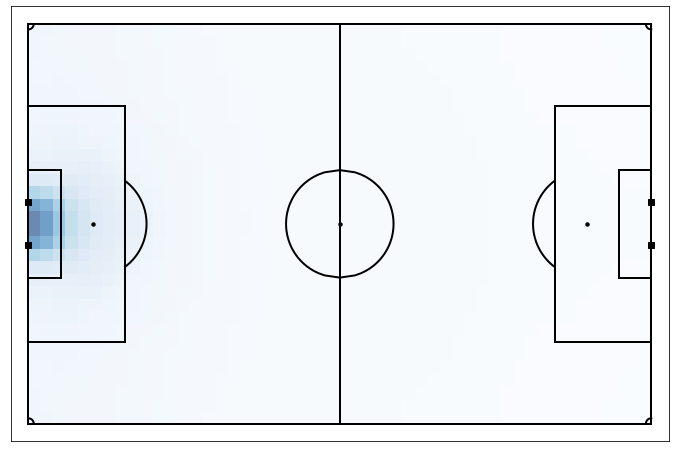

In [78]:
# plot the EPV surface
mviz.plot_EPV(EPV,field_dimen=(106.0,68),attack_direction=home_attack_direction)

In [79]:
EPV.shape

(32, 50)

In [80]:
EPV[0]

array([0.0046, 0.0046, 0.0045, 0.0046, 0.0048, 0.0051, 0.0054, 0.0057,
       0.0059, 0.0062, 0.0066, 0.0068, 0.0071, 0.0072, 0.0073, 0.0077,
       0.0082, 0.0086, 0.0088, 0.0092, 0.0096, 0.01  , 0.0104, 0.011 ,
       0.0117, 0.0123, 0.0127, 0.0131, 0.0135, 0.0142, 0.015 , 0.016 ,
       0.017 , 0.0181, 0.0192, 0.0208, 0.0227, 0.0244, 0.0259, 0.0276,
       0.0297, 0.0313, 0.0326, 0.0341, 0.0356, 0.0365, 0.0368, 0.0388,
       0.0424, 0.0443])

In [81]:
def get_EPV_at_location(position,EPV,attack_direction,field_dimen=(106.,68.)):
    """ get_EPV_at_location
    
    Returns the EPV (Expected Possession Value) at a given (x,y) location
    
    Parameters
    -----------
        position: Tuple containing the (x,y) pitch position
        EPV: tuple Expected Possession value grid (loaded using load_EPV_grid() )
        attack_direction: Sets the attack direction (1: left->right, -1: right->left)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
            
    Returrns
    -----------
        EPV value at input position
        
    """
    
    x,y = position
    if abs(x)>field_dimen[0]/2. or abs(y)>field_dimen[1]/2.:
        return 0.0 # Position is off the field, EPV is zero
    else:
        if attack_direction==-1:
            EPV = np.fliplr(EPV)
        ny,nx = EPV.shape
        dx = field_dimen[0]/float(nx)
        dy = field_dimen[1]/float(ny)
        ix = (x+field_dimen[0]/2.-0.0001)/dx
        iy = (y+field_dimen[1]/2.-0.0001)/dy
        return EPV[int(iy),int(ix)]

### Breaking Apart `get_EPV_at_location()`

In [82]:
position=(0,0)
EPV=EPV
attack_direction=mio.find_playing_direction(team, teamname)
field_dimen=(106.,68.)

In [83]:
x,y = position
x, y

(0, 0)

In [84]:
# if x or y position is > 1/2 of corresponding x or y field_dimen, means position is off field, so set EPV to zero
if abs(x)>field_dimen[0]/2. or abs(y)>field_dimen[1]/2.:
    0.0 # Position is off the field, EPV is zero
# check if attack_direction is opposite of default EPV to flip EPV
else:
    if attack_direction==-1:
        EPV = np.fliplr(EPV)

In [85]:
EPV = np.fliplr(EPV)
EPV

array([[0.0443, 0.0424, 0.0388, ..., 0.0045, 0.0046, 0.0046],
       [0.0437, 0.0421, 0.0388, ..., 0.0045, 0.0044, 0.0044],
       [0.0425, 0.0413, 0.0388, ..., 0.0044, 0.0042, 0.0041],
       ...,
       [0.0425, 0.0413, 0.0388, ..., 0.0044, 0.0042, 0.0041],
       [0.0437, 0.0421, 0.0388, ..., 0.0045, 0.0044, 0.0044],
       [0.0443, 0.0424, 0.0388, ..., 0.0045, 0.0046, 0.0046]])

In [86]:
EPV.shape

(32, 50)

In [87]:
# seeing values flip l->r with np.fliplr(EPV)
# rows 15-16 are center of goal
EPV[15]

array([0.5714, 0.4915, 0.3319, 0.2252, 0.1716, 0.1362, 0.119 , 0.1027,
       0.0875, 0.0707, 0.0523, 0.0408, 0.0362, 0.0315, 0.0267, 0.0237,
       0.0225, 0.0211, 0.0195, 0.0181, 0.0168, 0.0162, 0.0164, 0.0156,
       0.0139, 0.0133, 0.0137, 0.0136, 0.013 , 0.0124, 0.0118, 0.0114,
       0.0112, 0.0108, 0.0103, 0.0099, 0.0095, 0.0092, 0.0088, 0.0085,
       0.0083, 0.0083, 0.0085, 0.0085, 0.0082, 0.0079, 0.0076, 0.0077,
       0.0083, 0.0085])

In [88]:
EPV[16]

array([0.5714, 0.4915, 0.3319, 0.2252, 0.1716, 0.1362, 0.119 , 0.1027,
       0.0875, 0.0707, 0.0523, 0.0408, 0.0362, 0.0315, 0.0267, 0.0237,
       0.0225, 0.0211, 0.0195, 0.0181, 0.0168, 0.0162, 0.0164, 0.0156,
       0.0139, 0.0133, 0.0137, 0.0136, 0.013 , 0.0124, 0.0118, 0.0114,
       0.0112, 0.0108, 0.0103, 0.0099, 0.0095, 0.0092, 0.0088, 0.0085,
       0.0083, 0.0083, 0.0085, 0.0085, 0.0082, 0.0079, 0.0076, 0.0077,
       0.0083, 0.0085])

### Pitch Control

### Set default parameters for Pitch Control

In [89]:
# first get pitch control model parameters
params = mpc.default_model_params()

In [90]:
params

{'max_player_accel': 7.0,
 'max_player_speed': 5.0,
 'reaction_time': 0.7,
 'tti_sigma': 0.45,
 'kappa_def': 1.0,
 'lambda_att': 4.3,
 'lambda_def': 4.3,
 'lambda_gk': 12.899999999999999,
 'average_ball_speed': 15.0,
 'int_dt': 0.04,
 'max_int_time': 10,
 'model_converge_tol': 0.01,
 'time_to_control_att': 3.3202550055547313,
 'time_to_control_def': 3.3202550055547313}

### Unfinished documentation begins here

In [91]:
def calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params):
    """ calculate_pitch_control_at_target
    
    Calculates the pitch control probability for the attacking and defending teams at a specified target position on the ball.
    
    Parameters
    -----------
        target_position: size 2 numpy array containing the (x,y) position of the position on the field to evaluate pitch control
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_start_pos: Current position of the ball (start position for a pass). If set to NaN, function will assume that the ball is already at the target position.
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returrns
    -----------
        PPCFatt: Pitch control probability for the attacking team
        PPCFdef: Pitch control probability for the defending team ( 1-PPCFatt-PPCFdef <  params['model_converge_tol'] )

    """
    # calculate ball travel time from start position to end position.
    if ball_start_pos is None or any(np.isnan(ball_start_pos)): # assume that ball is already at location
        ball_travel_time = 0.0 
    else:
        # ball travel time is distance to target position from current ball position divided assumed average ball speed
        ball_travel_time = np.linalg.norm( target_position - ball_start_pos )/params['average_ball_speed']
    
    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity)
    tau_min_att = np.nanmin( [p.simple_time_to_intercept(target_position) for p in attacking_players] )
    tau_min_def = np.nanmin( [p.simple_time_to_intercept(target_position ) for p in defending_players] )
    
    # check whether we actually need to solve equation 3
    if tau_min_att-max(ball_travel_time,tau_min_def) >= params['time_to_control_def']:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= params['time_to_control_att']:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in attacking_players if p.time_to_intercept-tau_min_att < params['time_to_control_att'] ]
        defending_players = [p for p in defending_players if p.time_to_intercept-tau_min_def < params['time_to_control_def'] ]
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-params['int_dt'],ball_travel_time+params['max_int_time'],params['int_dt']) 
        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit (see 'params')
        ptot = 0.0
        i = 1
        while 1-ptot>params['model_converge_tol'] and i<dT_array.size: 
            T = dT_array[i]
            for player in attacking_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_att
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFatt[i] += player.PPCF # add to sum over players in the attacking team (remembering array element is zero at the start of each integration iteration)
            for player in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_def
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFdef[i] += player.PPCF # add to sum over players in the defending team
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
        return PPCFatt[i-1], PPCFdef[i-1]

### Get all shots and passes

In [92]:
# first get all shots
shots = events[events['Type']=='SHOT']
home_shots = shots[shots['Team']=='Home']
away_shots = shots[shots['Team']=='Away']
# get all  passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]
away_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Away') ]

In [93]:
home_passes

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
28,Home,PASS,NaN,1,1467,58.68,1489,59.56,Player1,Player11,46.64,21.08,53.00,10.20
29,Home,PASS,NaN,1,1489,59.56,1578,63.12,Player11,Player9,53.00,10.20,9.54,24.48
36,Home,PASS,HEAD,1,1672,66.88,1693,67.72,Player6,Player7,19.08,14.96,19.08,8.84
52,Home,PASS,NaN,1,2414,96.56,2440,97.60,Player3,Player8,16.96,-24.48,1.06,-29.92
53,Home,PASS,NaN,1,2465,98.60,2493,99.72,Player8,Player4,2.12,-29.92,10.60,-31.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1913,Home,PASS,NaN,2,137130,5485.20,137176,5487.04,Player5,Player1,-3.18,0.00,8.48,-12.92
1914,Home,PASS,NaN,2,137209,5488.36,137221,5488.84,Player1,Player6,9.54,-12.24,4.24,-4.76
1915,Home,PASS,NaN,2,137263,5490.52,137303,5492.12,Player6,Player1,4.24,-12.24,12.72,-21.76
1916,Home,PASS,NaN,2,137303,5492.12,137332,5493.28,Player1,Player5,12.72,-21.76,1.06,-26.52


In [94]:
# home team EPV added for passes
home_pass_value_added = []
for i,pass_ in home_passes.iterrows():
    EEPV_added, EPV_diff = mepv.calculate_epv_added( i, events, tracking_home, tracking_away, GK_numbers, EPV, params)
    home_pass_value_added.append( (i,EEPV_added,EPV_diff ) )

In [95]:
# away team EPV added for passes
away_pass_value_added = []
for i,pass_ in away_passes.iterrows():
    EEPV_added, EPV_diff = mepv.calculate_epv_added( i, events, tracking_home, tracking_away, GK_numbers, EPV, params)
    away_pass_value_added.append( (i,EEPV_added,EPV_diff ) )

In [153]:
# index 1 with i (index number of pass), EPV_added, EPV_diff
home_pass_value_added[1]

(29, -0.002484448442229724, 0.004699999999999999)

In [160]:
# EPV added
home_pass_value_added[1][1]

0.07256624699798692

In [154]:
home_pass_value_added = sorted(home_pass_value_added, key = lambda x: x[1], reverse=True)  
away_pass_value_added = sorted(away_pass_value_added, key = lambda x: x[1], reverse=True)  

In [156]:
home_pass_value_added[:5]

[(1753, 0.09134393894242623, 0.2252),
 (1478, 0.07256624699798692, 0.36379999999999996),
 (197, 0.06171398533066253, 0.2444),
 (430, 0.048489233171870066, 0.10749999999999998),
 (851, 0.04528996595787502, 0.1001)]

In [157]:
away_pass_value_added[:5]

[(1663, 0.07350679988214359, 0.0378),
 (961, 0.07103134497968046, 0.1555),
 (1901, 0.06363375695912829, 0.2474),
 (822, 0.052764729064602174, 0.0664),
 (1735, 0.0318116338246547, -0.005600000000000001)]

In [19]:
print("Top 5 home team passes by expected EPV-added")
print(home_pass_value_added[:5])
print("Top 5 away team passes by expected EPV-added")
print(away_pass_value_added[:5])

Top 5 home team passes by expected EPV-added
[(1753, 0.09134393894242623, 0.2252), (1478, 0.07256624699798692, 0.36379999999999996), (197, 0.06171398533066253, 0.2444), (430, 0.048489233171870066, 0.10749999999999998), (851, 0.04528996595787502, 0.1001)]
Top 5 away team passes by expected EPV-added
[(1663, 0.07350679988214359, 0.0378), (961, 0.07103134497968046, 0.1555), (1901, 0.06363375695912829, 0.2474), (822, 0.052764729064602174, 0.0664), (1735, 0.0318116338246547, -0.005600000000000001)]


In [21]:
# import ffmpeg
import matplotlib.animation as animation
animation.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'


In [21]:
# fpath = '/Users/jeromekirkpatrick/Desktop/galvanize/sample-data'
# fname = 'clip_40sec'
# hometeam_ss=tracking_home[0:1000]
# awayteam_ss=tracking_away[0:1000]

In [22]:
# save_match_clip(hometeam_ss, awayteam_ss, fpath, fname=fname, include_player_velocities=True)

In [23]:
# # import ffmpeg
# # import matplotlib.animation as animation
# # animation.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

# fpath = '/Users/jeromekirkpatrick/Desktop/galvanize/sample-data'
# fname = 'clip_4sec'
# hometeam_ss=tracking_home[0:100]
# awayteam_ss=tracking_away[0:100]
# mviz.save_match_clip(hometeam_ss, awayteam_ss, fpath, fname=fname, include_player_velocities=False)

In [24]:
# events['Type'][events['Type']=='PASS']

In [25]:
def plot_pitch( field_dimen = (106.0,68.0), field_color ='white', linewidth=2, markersize=20):
    """ plot_pitch
    
    Plots a soccer pitch. All distance units converted to meters.
    
    Parameters
    -----------
        field_dimen: (length, width) of field in meters. Default is (106,68)
        field_color: color of field. options are {'green','white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    fig,ax = plt.subplots(figsize=(12,8)) # create a figure 
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke' # line color
        pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1] 
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)
        
    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    return fig,ax

In [ ]:
def my_plot_pitch( field_dimen = (106.0,68.0), field_color ='white', linewidth=2, markersize=20):
    """ plot_pitch
    
    Plots a soccer pitch. All distance units converted to meters.
    
    Parameters
    -----------
        field_dimen: (length, width) of field in meters. Default is (106,68)
        field_color: color of field. options are {'green','white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    fig,ax = plt.subplots(figsize=(12,8)) # create a figure 
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke' # line color
        pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1] 
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)
        
    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    return fig,ax

In [26]:
# def plot_frame( hometeam, awayteam, figax=None, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):
#     """ plot_frame( hometeam, awayteam )
    
#     Plots a frame of Metrica tracking data (player positions and the ball) on a football pitch. All distances should be in meters.
    
#     Parameters
#     -----------
#         hometeam: row (i.e. instant) of the home team tracking data frame
#         awayteam: row of the away team tracking data frame
#         fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot, 
#         team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
#         field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
#         include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
#         PlayerMarkerSize: size of the individual player marlers. Default is 10
#         PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
#         annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        
#     Returrns
#     -----------
#        fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

#     """
#     if figax is None: # create new pitch 
#         fig,ax = plot_pitch( field_dimen = field_dimen )
#     else: # overlay on a previously generated pitch
#         fig,ax = figax # unpack tuple
#     # plot home & away teams in order
#     for team,color in zip( [hometeam,awayteam], team_colors) :
#         x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
#         y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
#         ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
#         if include_player_velocities:
#             vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
#             vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
#             ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
#         if annotate:
#             [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color=color  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ] 
#     # plot ball
#     ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'wo', markeredgecolor='k', markeredgewidth=1.5, MarkerSize=6, alpha=1.0, LineWidth=0)
#     return fig,ax

In [28]:
# def my_plot_frame( hometeam, awayteam, figax=None, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):
#     """ plot_frame( hometeam, awayteam )
    
#     Plots a frame of Metrica tracking data (player positions and the ball) on a football pitch. All distances should be in meters.
    
#     Parameters
#     -----------
#         hometeam: row (i.e. instant) of the home team tracking data frame
#         awayteam: row of the away team tracking data frame
#         fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot, 
#         team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
#         field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
#         include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
#         PlayerMarkerSize: size of the individual player marlers. Default is 10
#         PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
#         annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        
#     Returrns
#     -----------
#        fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

#     """
#     # COMMENTING OUT FROM HERE TO...
# #     if figax is None: # create new pitch 
# #         fig,ax = plot_pitch( field_dimen = field_dimen )
# #     else: # overlay on a previously generated pitch
# #         fig,ax = figax # unpack tuple
#     # HERE.
    
#     # inserted this
#     ax=figax # figax just an ax
    
#     # plot home & away teams in order
#     for team,color in zip( [hometeam,awayteam], team_colors) :
#         x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
#         y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
#         ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
#         if include_player_velocities:
#             vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
#             vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
#             ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
#         if annotate:
#             [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color=color  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ] 
#     # plot ball
# #     ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
#     return ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)# original fix, ax

In [29]:
# def my_generate_pitch_control_for_frame(frame, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True):
#     """ generate_pitch_control_for_event
    
#     Evaluates pitch control surface over the entire field at the moment of the given event (determined by the index of the event passed as an input)
    
#     Parameters
#     -----------
#         event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
#         events: Dataframe containing the event data
#         tracking_home: tracking DataFrame for the Home team
#         tracking_away: tracking DataFrame for the Away team
#         params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
#         GK_numbers: tuple containing the player id of the goalkeepers for the (home team, away team)
#         field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
#         n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
#                         n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
#         offsides: If True, find and remove offside atacking players from the calculation. Default is True.
        
#     UPDATE (tutorial 4): Note new input arguments ('GK_numbers' and 'offsides')
        
#     Returrns
#     -----------
#         PPCFa: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team.
#                Surface for the defending team is just 1-PPCFa.
#         xgrid: Positions of the pixels in the x-direction (field length)
#         ygrid: Positions of the pixels in the y-direction (field width)

#     """
#     # testing
#     pass_frame = frame
    
#     # commenting out for now to...
#     # get the details of the event (frame, team in possession, ball_start_position)
# #     pass_frame = events.loc[event_id]['Start Frame']
# #     pass_team = events.loc[event_id].Team
#     # here.
    
#     # WHAT DO I DO ABOUT NANS HERE??
#     ball_start_pos = np.array([events.loc[event_id]['Start X'],events.loc[event_id]['Start Y']]) # commenting out
#     # break the pitch down into a grid
#     n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
#     dx = field_dimen[0]/n_grid_cells_x
#     dy = field_dimen[1]/n_grid_cells_y
#     xgrid = np.arange(n_grid_cells_x)*dx - field_dimen[0]/2. + dx/2.
#     ygrid = np.arange(n_grid_cells_y)*dy - field_dimen[1]/2. + dy/2.
#     # initialise pitch control grids for attacking and defending teams 
#     PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
#     PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    
#     # TEST - initialize regardless of who has ball...
#     # doesn't seem to matter who has ball anyway
#     # adding mpc. to initialise_players
#     attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params,GK_numbers[0])
#     defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params,GK_numbers[1])
    
#     # commenting out from here to...
#     # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
# #     if pass_team=='Home':
# #         attacking_players = initialise_players(tracking_home.loc[pass_frame],'Home',params,GK_numbers[0])
# #         defending_players = initialise_players(tracking_away.loc[pass_frame],'Away',params,GK_numbers[1])
# #     elif pass_team=='Away':
# #         defending_players = initialise_players(tracking_home.loc[pass_frame],'Home',params,GK_numbers[0])
# #         attacking_players = initialise_players(tracking_away.loc[pass_frame],'Away',params,GK_numbers[1])
# #     else:
# #         assert False, "Team in possession must be either home or away"
#     # here.
        
#     # find any attacking players that are offside and remove them from the pitch control calculation
#     if offsides:
#         attacking_players = mpc.check_offsides( attacking_players, defending_players, ball_start_pos, GK_numbers)
#     # calculate pitch pitch control model at each location on the pitch
#     for i in range( len(ygrid) ):
#         for j in range( len(xgrid) ):
#             target_position = np.array( [xgrid[j], ygrid[i]] )
#             PPCFa[i,j],PPCFd[i,j] = mpc.calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params)
#     # check probabilitiy sums within convergence
#     checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
#     assert 1-checksum < params['model_converge_tol'], "Checksum failed: %1.3f" % (1-checksum)
#     return PPCFa,xgrid,ygrid



In [30]:
# # def my_plot_pitchcontrol_for_frame( frame, tracking_home, tracking_away, ax, PPCF, alpha = 0.7, include_player_velocities=True, annotate=False, field_dimen = (106.0,68)):
# #     """ plot_pitchcontrol_for_event( event_id, events,  tracking_home, tracking_away, PPCF )
    
# #     Plots the pitch control surface at the instant of the event given by the event_id. Player and ball positions are overlaid.
    
# #     Parameters
# #     -----------
# #         event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
# #         events: Dataframe containing the event data
# #         tracking_home: (entire) tracking DataFrame for the Home team
# #         tracking_away: (entire) tracking DataFrame for the Away team
# #         PPCF: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team (as returned by the generate_pitch_control_for_event in Metrica_PitchControl)
# #         alpha: alpha (transparency) of player markers. Default is 0.7
# #         include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
# #         annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
# #         field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        
# #     NB: this function no longer requires xgrid and ygrid as an input
        
# #     Returrns
# #     -----------
# #        fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

# #     """    
# #     figobjs = [] #added this
# #     # can I get a frame from tracking_home
# #     pass_frame = frame
# # #     # pick a pass at which to generate the pitch control surface
# # #     pass_frame = events.loc[event_id]['Start Frame']
# # #     pass_team = events.loc[event_id].Team
    
# #     # plot frame and event
# # #     fig,ax = plot_pitch(field_color='white', field_dimen = field_dimen)
# #     # switched figax from  (fig,ax) to ax and assigned to variable objs
# #     objs = my_plot_frame( tracking_home.loc[pass_frame], tracking_away.loc[pass_frame], figax=ax, PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
# # #     plot_events( events.loc[event_id:event_id], figax = (fig,ax), indicators = ['Marker','Arrow'], annotate=False, color= 'k', alpha=1 )
# #     figobjs.append(objs)
# #     # plot pitch control surface
# # #     if pass_team=='Home':
# # #         cmap = 'bwr'
# # #     else:
# # #         cmap = 'bwr_r'
# # #     ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),interpolation='spline36',vmin=0.0,vmax=1.0,cmap='bwr',alpha=0.5)
# #     objs = ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),interpolation='spline36',vmin=0.0,vmax=1.0,cmap='bwr',alpha=0.5)
# #     figobjs.append(objs)
# #     return figobjs #list of objs in figobjs

# def my_plot_pitchcontrol_for_frame(frame, tracking_home, tracking_away, PPCF, alpha = 0.7, include_player_velocities=True, annotate=False, field_dimen = (106.0,68)):
#     """ plot_pitchcontrol_for_event( event_id, events,  tracking_home, tracking_away, PPCF )
    
#     Plots the pitch control surface at the instant of the event given by the event_id. Player and ball positions are overlaid.
    
#     Parameters
#     -----------
#         event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
#         events: Dataframe containing the event data
#         tracking_home: (entire) tracking DataFrame for the Home team
#         tracking_away: (entire) tracking DataFrame for the Away team
#         PPCF: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team (as returned by the generate_pitch_control_for_event in Metrica_PitchControl)
#         alpha: alpha (transparency) of player markers. Default is 0.7
#         include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
#         annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
#         field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        
#     NB: this function no longer requires xgrid and ygrid as an input
        
#     Returrns
#     -----------
#        fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

#     """    

#     # pick a pass at which to generate the pitch control surface
#     pass_frame = frame
# #     pass_team = events.loc[event_id].Team
    
#     # plot frame and event
#     fig,ax = mviz.plot_pitch(field_color='white', field_dimen = field_dimen)
#     plot_frame( tracking_home.loc[pass_frame], tracking_away.loc[pass_frame], figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
# #     plot_events( events.loc[event_id:event_id], figax = (fig,ax), indicators = ['Marker','Arrow'], annotate=False, color= 'k', alpha=1 )
    
#     # plot pitch control surface
# #     if pass_team=='Home':
# #         cmap = 'bwr'
# #     else:
# #         cmap = 'bwr_r'
#     ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),interpolation='spline36',vmin=0.0,vmax=1.0,cmap='bwr',alpha=0.5)

#     return fig,ax



In [31]:
events

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,-4.24,18.36,22.26,-17.68
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,20.14,-13.60,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,19.08,-13.60,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,16.96,-12.24,NaN,NaN


In [32]:
frame = 140180
pass_frame = frame
# events.loc[frame]['Start Frame']==pass_frame
# pass_team = events['Team'][events['Start Frame']==pass_frame]

In [33]:
def frame_to_event(frame):
    if len(events.index[events['Start Frame']==frame])==0:
        return None
    else:
        return events.index[events['Start Frame']==frame][0]

In [34]:
frame = 140212
print(frame_to_event(frame))
frame = 140211
print(frame_to_event(frame))

None
1933


In [35]:
event = 1934
def event_to_frame(event):
    return events['Start Frame'][events.index[event]]
#     return events['Start Frame'][1933]

In [36]:
event_to_frame(event)

140265

Pass EPV added: 0.09


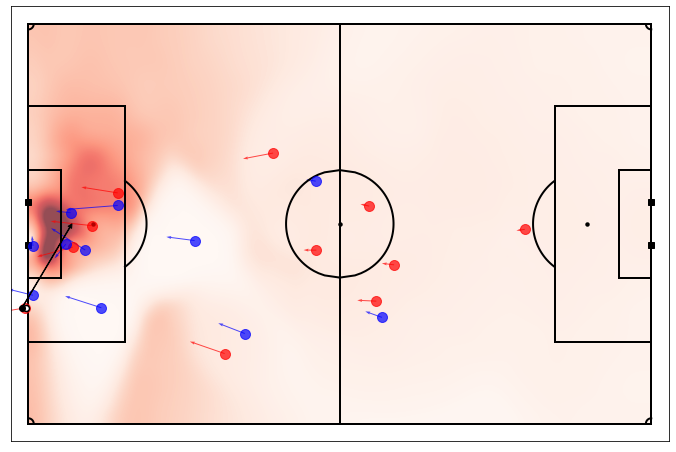

In [37]:
event_number = 1753 #home team assist to header off target
EEPV_added, EPV_diff = mepv.calculate_epv_added(event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event(event_number, events, tracking_home, tracking_away, PPCF, EPV, annotate=False)
# fig.suptitle('Pass EPV added: %1.3f' % EEPV_added, y=0.95)
print(f'Pass EPV added: {EEPV_added:.2f}')
# mviz.plot_pitchcontrol_for_event( event_number, events,  tracking_home, tracking_away, PPCF, annotate=False)

In [38]:
# returns event_type, event_subtype, eventid

def my_event_info(pass_frame):    
    # check if there is any event for this frame
    if events['Type'].loc[events['Start Frame']==pass_frame].empty:
        return None

    # check if there is more than one event for this frame   
    elif len(events['Type'].loc[events['Start Frame']==pass_frame]) > 1:
        curr_type = events['Type'].loc[events['Start Frame']==pass_frame].iloc[1]
        curr_type = pd.Series([curr_type])
        curr_eventid = events.index[events['Start Frame']==pass_frame].to_list()[1]

        if events['Subtype'].loc[events['Start Frame']==pass_frame].notnull().all():
            curr_subtype = events['Subtype'].loc[events['Start Frame']==pass_frame]
        else:
            curr_subtype = ''
    
    # only one event for this frame
    else:
        curr_type = events['Type'].loc[events['Start Frame']==pass_frame]
        curr_eventid = events.index[events['Start Frame']==pass_frame].to_list()[0]

        if events['Subtype'].loc[events['Start Frame']==pass_frame].notnull().all():
            curr_subtype = events['Subtype'].loc[events['Start Frame']==pass_frame]
        else:
            curr_subtype = ''
    
    return curr_type, curr_subtype, curr_eventid

In [39]:
curr_type, curr_subtype, curr_eventid = my_event_info(51)
curr_type.item()

'PASS'

In [40]:
events['Type'].value_counts()

PASS              964
CHALLENGE         311
RECOVERY          248
BALL LOST         233
SET PIECE          80
BALL OUT           49
SHOT               24
FAULT RECEIVED     20
CARD                6
Name: Type, dtype: int64

In [41]:
events['Subtype'][events['Type']=='SHOT']

83           OFF TARGET-OUT
198          ON TARGET-GOAL
252         ON TARGET-SAVED
297                 BLOCKED
431     HEAD-OFF TARGET-OUT
472         ON TARGET-SAVED
823          ON TARGET-GOAL
852     HEAD-OFF TARGET-OUT
962     OFF TARGET-HEAD-OUT
980         ON TARGET-SAVED
1026         OFF TARGET-OUT
1058         OFF TARGET-OUT
1118    HEAD-ON TARGET-GOAL
1277         OFF TARGET-OUT
1335        ON TARGET-SAVED
1479        ON TARGET-SAVED
1666                BLOCKED
1671         ON TARGET-GOAL
1681    HEAD-OFF TARGET-OUT
1723         ON TARGET-GOAL
1756    HEAD-OFF TARGET-OUT
1843         OFF TARGET-OUT
1903    HEAD-OFF TARGET-OUT
1927        ON TARGET-SAVED
Name: Subtype, dtype: object

In [42]:
events['Subtype'][events['Type']=='CHALLENGE'].value_counts()

TACKLE-LOST              51
GROUND-LOST              48
GROUND-WON               43
TACKLE-WON               37
AERIAL-WON               35
AERIAL-LOST              30
GROUND-FAULT-LOST        17
GROUND-FAULT-WON         11
TACKLE-FAULT-WON          9
TACKLE-FAULT-LOST         6
AERIAL-FAULT-LOST         4
GROUND-ADVANTAGE-LOST     4
GROUND                    4
TACKLE-ADVANTAGE-WON      3
AERIAL-FAULT-WON          3
GROUND-ADVANTAGE-WON      3
DRIBBLE-WON               1
TACKLE-ADVANTAGE-LOST     1
FAULT-WON                 1
Name: Subtype, dtype: int64

In [43]:
events['Subtype'].value_counts()

INTERCEPTION                   259
THEFT                           69
TACKLE-LOST                     51
GROUND-LOST                     48
GROUND-WON                      43
HEAD                            41
TACKLE-WON                      37
AERIAL-WON                      35
THROW IN                        32
FREE KICK                       30
AERIAL-LOST                     30
GROUND-FAULT-LOST               17
HEAD-INTERCEPTION               15
GOAL KICK                       12
GROUND-FAULT-WON                11
TACKLE-FAULT-WON                 9
CROSS                            8
CROSS-INTERCEPTION               8
KICK OFF                         7
CLEARANCE                        7
CORNER KICK                      7
YELLOW                           6
FORCED                           6
TACKLE-FAULT-LOST                6
SAVED                            6
ON TARGET-SAVED                  6
BLOCKED                          5
HEAD-OFF TARGET-OUT              5
OFF TARGET-OUT      

In [47]:
# get all  passes
passes = events[events['Type'].isin(['PASS'])]
passes

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44
5,Away,PASS,NaN,1,395,15.80,423,16.92,Player16,Player15,-25.44,-10.88,-24.38,-27.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,Home,PASS,NaN,2,137209,5488.36,137221,5488.84,Player1,Player6,9.54,-12.24,4.24,-4.76
1915,Home,PASS,NaN,2,137263,5490.52,137303,5492.12,Player6,Player1,4.24,-12.24,12.72,-21.76
1916,Home,PASS,NaN,2,137303,5492.12,137332,5493.28,Player1,Player5,12.72,-21.76,1.06,-26.52
1917,Home,PASS,NaN,2,137334,5493.36,137359,5494.36,Player5,Player1,1.06,-26.52,15.90,-26.52


In [49]:
EPV_added = ''
EPV_added, EPV_dif = mepv.my_calculate_epv_added(51,passes=passes,tracking_home=hometeam,tracking_away=awayteam,GK_numbers=GK_numbers, EPV=EPV, params=params)
objs = ax.text(0,55, f'PASS EPV: {EPV_added:.3f}', fontsize=14, ha='center')
EPV_added
f'PASS EPV: {EPV_added:.3f}'

'PASS EPV: -0.001'

In [52]:
passes

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44
5,Away,PASS,NaN,1,395,15.80,423,16.92,Player16,Player15,-25.44,-10.88,-24.38,-27.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,Home,PASS,NaN,2,137209,5488.36,137221,5488.84,Player1,Player6,9.54,-12.24,4.24,-4.76
1915,Home,PASS,NaN,2,137263,5490.52,137303,5492.12,Player6,Player1,4.24,-12.24,12.72,-21.76
1916,Home,PASS,NaN,2,137303,5492.12,137332,5493.28,Player1,Player5,12.72,-21.76,1.06,-26.52
1917,Home,PASS,NaN,2,137334,5493.36,137359,5494.36,Player5,Player1,1.06,-26.52,15.90,-26.52


In [56]:
for i in range(100):
    if i in passes['Start Frame'].to_list():
        # calculate EPV
        EPV_added, EPV_dif = mepv.my_calculate_epv_added(i, passes, tracking_home, tracking_away, GK_numbers, EPV, params)
        print(i)
        print(EPV_added, EPV_dif)
        

51
-0.001430979587408494 -0.0014999999999999996


In [68]:
def my_ppcf_save_match_clip(hometeam, awayteam, fpath, events=events, EPV=EPV, passes=passes, GK_numbers=GK_numbers, params=params, fname='clip_test', figax=None, frames_per_second=25, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=True, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False):
    """ save_match_clip( hometeam, awayteam, fpath )
    
    Generates a movie from Metrica tracking data, saving it in the 'fpath' directory with name 'fname'
    
    Parameters
    -----------
        hometeam: home team tracking data DataFrame. Movie will be created from all rows in the DataFrame
        awayteam: away team tracking data DataFrame. The indices *must* match those of the hometeam DataFrame
        fpath: directory to save the movie
        fname: movie filename. Default is 'clip_test.mp4'
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot,
        frames_per_second: frames per second to assume when generating the movie. Default is 25.
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    # check that indices match first
    assert np.all( hometeam.index==awayteam.index ), "Home and away team Dataframe indices must be the same"
    # in which case use home team index
    index = hometeam.index
    # Set figure and movie settings
    FFMpegWriter = animation.writers['ffmpeg'] # original: animation.writers['ffmpeg'] follow-up: animation.FFMpegFileWriter()
    metadata = dict(title='Tracking Data', artist='Matplotlib', comment='Metrica tracking data clip')
    writer = FFMpegWriter(fps=frames_per_second, metadata=metadata)
    fname = fpath + '/' +  fname + '.mp4' # path and filename
    # create football pitch
    if figax is None:
        fig,ax = mviz.plot_pitch(field_dimen=field_dimen, field_color ='white')
    else:
        fig,ax = figax
    fig.set_tight_layout(True)
    # Generate movie
    print("Generating movie...",end='')
    
    # instantiate my_event_info() return variables outside loop
    curr_type = ''
    curr_subtype = ''
    # including event_id, not using for now
    curr_eventid = ''
    # initialize EPV_added as empty string
    EPV_added = ''
    
    with writer.saving(fig, fname, 100):
        count = 1
        
        for i in index:
            
            figobjs = [] # this is used to collect up all the axis objects so that they can be deleted after each iteration
            
            # check if frame is an instance of a pass
            if i in passes['Start Frame'].to_list():
                # calculate EPV
                EPV_added, EPV_dif = mepv.my_calculate_epv_added(frame=i,passes=passes,tracking_home=hometeam,tracking_away=awayteam,GK_numbers=GK_numbers, EPV=EPV, params=params) # 'passes', 'tracking_home', 'tracking_away', 'GK_numbers', 'EPV', and 'params'
                
            
            # generate pitch control plot for frame
            PPCF, xgrid, ygrid = mpc.my_generate_pitch_control_for_frame(i, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
            objs = ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),interpolation='spline36',vmin=0.0,vmax=1.0,cmap='bwr',alpha=0.5)
            figobjs.append(objs)
                
            for team,color in zip( [hometeam.loc[i],awayteam.loc[i]], team_colors) :
                x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
                y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
                objs, = ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
                figobjs.append(objs)
                if include_player_velocities:
                    vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
                    vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
                    objs = ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
                    figobjs.append(objs)
                                    
            # plot ball
            objs, = ax.plot( team['ball_x'], team['ball_y'], 'wo', markeredgecolor='k', markeredgewidth=1.5, MarkerSize=6, alpha=1.0, LineWidth=0)
            figobjs.append(objs)
    
            # create text ax to add to objs to plot
            # include match time at the top
            frame_minute =  int( hometeam.loc[i]['Time [s]']/60. )
            frame_second =  ( hometeam.loc[i]['Time [s]']/60. - frame_minute ) * 60.
            timestring = "%d:%1.2f" % ( frame_minute, frame_second  )
            
            # EPV_added
            if EPV_added:
                objs = ax.text(0,field_dimen[1]/2. +1., f'PASS EPV: {EPV_added:.3f}', fontsize=14, ha='center')
                figobjs.append(objs)
            
            # time and frame
            objs = ax.text(55,field_dimen[1]/2. +1., f'TIME: {timestring} - FRAME: {str(i)}', fontsize=14, ha='right')
            figobjs.append(objs)
            
            # include event type and subtype
            event_outcome = my_event_info(i)
            if type(event_outcome) == tuple:
                curr_type, curr_subtype, curr_eventid = event_outcome
            
            # type and subtype
            if len(curr_type) != 0:
                if len(curr_subtype) != 0:
                    objs = ax.text(-55,field_dimen[1]/2. +1., f'{curr_type.item()} - {curr_subtype.item()}', fontsize=14, ha='left') # {curr_subtype}
                    figobjs.append(objs)
                else:
                    objs = ax.text(-55,field_dimen[1]/2. +1., f'{curr_type.item()}', fontsize=14, ha='left') # {curr_type}
                    figobjs.append(objs)            
            
            writer.grab_frame()
            print(f'frame: {count}')
            count += 1
            # Delete all axis objects (other than pitch lines) in preperation for next frame
            for figobj in figobjs:
                figobj.remove()
                
    print('\n',"done")
    plt.clf()
    plt.close(fig)    

## Don't need my_plot_pitch in Metrica_Viz.py, because same as plot_pitch in Metrica_Viz.py. Same for Viz.py.

In [67]:
hometeam = tracking_home[15150:15300]
awayteam = tracking_away[15150:15300]
fpath = '/Users/jeromekirkpatrick/Desktop'
fname = 'ppcf_test15000'
my_ppcf_save_match_clip(hometeam,awayteam, fpath, fname=fname, figax=None, frames_per_second=25, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=True, PlayerMarkerSize=10, PlayerAlpha=0.7)

Generating movie...frame: 1
frame: 2
frame: 3
frame: 4
frame: 5
frame: 6
frame: 7
frame: 8
frame: 9
frame: 10
frame: 11
frame: 12
frame: 13
frame: 14
frame: 15
frame: 16
frame: 17
frame: 18
frame: 19
frame: 20
frame: 21
frame: 22
frame: 23
frame: 24
frame: 25
frame: 26
frame: 27
frame: 28
frame: 29
frame: 30
frame: 31
frame: 32
frame: 33
frame: 34
frame: 35
frame: 36
frame: 37
frame: 38
frame: 39
frame: 40
frame: 41
frame: 42
frame: 43
frame: 44
frame: 45
frame: 46
frame: 47
frame: 48
frame: 49
frame: 50
frame: 51
frame: 52
frame: 53
frame: 54
frame: 55
frame: 56
frame: 57
frame: 58
frame: 59
frame: 60
frame: 61
frame: 62
frame: 63
frame: 64
frame: 65
frame: 66
frame: 67
frame: 68
frame: 69
frame: 70
frame: 71
frame: 72
frame: 73
frame: 74
frame: 75
frame: 76
frame: 77
frame: 78
frame: 79
frame: 80
frame: 81
frame: 82
frame: 83
frame: 84
frame: 85
frame: 86
frame: 87
frame: 88
frame: 89
frame: 90
frame: 91
frame: 92
frame: 93
frame: 94
frame: 95
frame: 96
frame: 97
frame: 98
frame: 99


In [53]:
# hometeam = tracking_home[50:801]
# awayteam = tracking_away[50:801]

# for i in range(50,802):
# #     print(i)
# #     test_lst.append(frame_to_event(i))
# #     print(frame_to_event(i))
#     # get event_num for frame
#     event_num_outcome = frame_to_event(i)
# #     print(event_num_outcome)
#     if isinstance(event_num_outcome,np.integer):
#         event_num = event_num_outcome.item()
#         print(event_num)
# #         # calculate EPV
# #         EPV_added, EPV_dif = mepv.calculate_epv_added(event_num, params, hometeam=hometeam, awayteam=awayteam, GK_numbers=GK_numbers, events=events, EPV=EPV)
# #         print(EPV_added)


In [55]:
frame = 51

if frame in passes['Start Frame'].to_list():

    pass_start_pos = np.array([passes['Start X'][passes['Start Frame']==frame].item(),passes['Start Y'][passes['Start Frame']==frame].item()])
    pass_target_pos = np.array([passes['End X'][passes['Start Frame']==frame].item(),passes['End Y'][passes['Start Frame']==frame].item()])
    pass_frame = frame
    pass_team = passes['Team'][passes['Start Frame']==frame].item()
    
    

In [56]:
print(pass_start_pos)
print(type(pass_start_pos))
print(pass_target_pos)
print(pass_frame)
print(pass_team)


[ 0. -0.]
<class 'numpy.ndarray'>
[-10.6   -0.68]
51
Away


In [61]:
# def my_calculate_epv_added(frame, passes=passes, tracking_home=hometeam, tracking_away=awayteam, GK_numbers=GK_numbers, EPV=EPV): # removing params for now
#     """ calculate_epv_added
    
#     Calculates the expected possession value added by a pass
    
#     Parameters
#     -----------
#         event_id: Index (not row) of the pass event to calculate EPV-added score
#         events: Dataframe containing the event data
#         tracking_home: tracking DataFrame for the Home team
#         tracking_away: tracking DataFrame for the Away team
#         GK_numbers: tuple containing the player id of the goalkeepers for the (home team, away team)
#         EPV: tuple Expected Possession value grid (loaded using load_EPV_grid() )
#         params: Dictionary of pitch control model parameters (default model parameters can be generated using default_model_params() )
        
#     Returrns
#     -----------
#         EEPV_added: Expected EPV value-added of pass defined by event_id
#         EPV_difference: The raw change in EPV (ignoring pitch control) between end and start points of pass

#     """
#     # pull out pass details from the passes data
#     pass_start_pos = np.array([passes['Start X'][passes['Start Frame']==frame].item(),passes['Start Y'][passes['Start Frame']==frame].item()])
#     pass_target_pos = np.array([passes['End X'][passes['Start Frame']==frame].item(),passes['End Y'][passes['Start Frame']==frame].item()])
#     pass_frame = frame
#     pass_team = passes['Team'][passes['Start Frame']==frame].item()
    
#     # direction of play for atacking team (so we know whether to flip the EPV grid)
#     home_attack_direction = mio.find_playing_direction(tracking_home,'Home')
#     if pass_team=='Home':
#         attack_direction = home_attack_direction
#         attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params,GK_numbers[0])
#         defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params,GK_numbers[1])
#     elif pass_team=='Away':
#         attack_direction = home_attack_direction*-1
#         defending_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params,GK_numbers[0])
#         attacking_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params,GK_numbers[1])    
#     # flag any players that are offside
#     attacking_players = mpc.check_offsides( attacking_players, defending_players, pass_start_pos, GK_numbers)
#     # pitch control grid at pass start location
#     Patt_start,_ = mpc.calculate_pitch_control_at_target(pass_start_pos, attacking_players, defending_players, pass_start_pos, params)
#     # pitch control grid at pass end location
#     Patt_target,_ = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)
    
#     # EPV at start location
#     EPV_start = mepv.get_EPV_at_location(pass_start_pos, EPV, attack_direction=attack_direction)
#     # EPV at end location
#     EPV_target = mepv.get_EPV_at_location(pass_target_pos,EPV,attack_direction=attack_direction)
    
#     # 'Expected' EPV at target and start location
#     EEPV_target = Patt_target*EPV_target
#     EEPV_start = Patt_start*EPV_start
    
#     # difference is the (expected) EPV added
#     EEPV_added = EEPV_target - EEPV_start
    
#     # Also calculate the straight up change in EPV
#     EPV_difference = EPV_target - EPV_start

#     return EEPV_added, EPV_difference

In [65]:
my_calculate_epv_added(frame)


(-0.001430979587408494, -0.0014999999999999996)

In [ ]:
passes


In [65]:
dir(mepv)


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'calculate_epv_added',
 'find_max_value_added_target',
 'get_EPV_at_location',
 'load_EPV_grid',
 'mio',
 'mpc',
 'my_calculate_epv_added',
 'np']

In [ ]:
params = mpc.default_model_params()


In [ ]:
frame=51
hometeam = tracking_home.loc[50:55]
awayteam = tracking_away.loc[50:55]


In [62]:
tracking_home.loc[50:55]
tracking_away.loc[50:55]


,Period,Time [s],Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,Away_17_y,...,Away_23_speed,Away_24_vx,Away_24_vy,Away_24_speed,Away_25_vx,Away_25_vy,Away_25_speed,Away_26_vx,Away_26_vy,Away_26_speed
Frame,,,,,,,,,,,,,,,,,,,,,
50,1,2.00,-52.66610,-0.19924,-12.16668,-21.79468,-20.29688,-4.48868,-19.63862,5.31760,...,0.307145,0.4505,0.306,0.544597,0.0000,0.000,0.000000,NaN,NaN,NaN
51,1,2.04,-52.66610,-0.19924,-12.16032,-21.80148,-20.29900,-4.48800,-19.65982,5.32576,...,0.425000,0.5035,0.323,0.598198,0.0000,0.000,0.000000,NaN,NaN,NaN
52,1,2.08,-52.66610,-0.19924,-12.15290,-21.80828,-20.30006,-4.48664,-19.67996,5.33528,...,0.100170,0.3975,0.323,0.512187,0.0000,0.000,0.000000,NaN,NaN,NaN
53,1,2.12,-52.66610,-0.19924,-12.14548,-21.81644,-20.30324,-4.48460,-19.70010,5.34480,...,0.157421,0.1855,0.153,0.240456,0.0000,0.000,0.000000,NaN,NaN,NaN
54,1,2.16,-52.66610,-0.19924,-12.13700,-21.82324,-20.30430,-4.48460,-19.71812,5.35092,...,0.180294,0.2915,0.340,0.447853,0.0000,0.000,0.000000,NaN,NaN,NaN
55,1,2.20,-52.66716,-0.19788,-12.12746,-21.82800,-20.30536,-4.48460,-19.73614,5.35704,...,0.228405,0.1855,0.170,0.251615,-0.0265,0.034,0.043107,NaN,NaN,NaN


In [61]:
mepv.my_calculate_epv_added(frame,params=params,passes=passes,tracking_home=hometeam,tracking_away=awayteam,GK_numbers=GK_numbers,EPV=EPV)


(-0.001430979587408494, -0.0014999999999999996)

In [ ]:
# def my_ppcf_save_match_clip(hometeam,awayteam, fpath, fname='clip_test', figax=None, frames_per_second=25, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=True, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False):
#     """ save_match_clip( hometeam, awayteam, fpath )
    
#     Generates a movie from Metrica tracking data, saving it in the 'fpath' directory with name 'fname'
    
#     Parameters
#     -----------
#         hometeam: home team tracking data DataFrame. Movie will be created from all rows in the DataFrame
#         awayteam: away team tracking data DataFrame. The indices *must* match those of the hometeam DataFrame
#         fpath: directory to save the movie
#         fname: movie filename. Default is 'clip_test.mp4'
#         fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot,
#         frames_per_second: frames per second to assume when generating the movie. Default is 25.
#         team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
#         field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
#         include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
#         PlayerMarkerSize: size of the individual player marlers. Default is 10
#         PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        
#     Returrns
#     -----------
#        fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

#     """
#     # check that indices match first
#     assert np.all( hometeam.index==awayteam.index ), "Home and away team Dataframe indices must be the same"
#     # in which case use home team index
#     index = hometeam.index
#     # Set figure and movie settings
#     FFMpegWriter = animation.writers['ffmpeg'] # original: animation.writers['ffmpeg'] follow-up: animation.FFMpegFileWriter()
#     metadata = dict(title='Tracking Data', artist='Matplotlib', comment='Metrica tracking data clip')
#     writer = FFMpegWriter(fps=frames_per_second, metadata=metadata)
#     fname = fpath + '/' +  fname + '.mp4' # path and filename
#     # create football pitch
#     if figax is None:
#         fig,ax = plot_pitch(field_dimen=field_dimen, field_color ='white')
#     else:
#         fig,ax = figax
#     fig.set_tight_layout(True)
#     # Generate movie
#     print("Generating movie...",end='')
#     with writer.saving(fig, fname, 100):
#         count = 1
#         for i in index:
            
#             figobjs = [] # this is used to collect up all the axis objects so that they can be deleted after each iteration
        
#             PPCF, xgrid, ygrid = my_generate_pitch_control_for_frame(i, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
#             objs = ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),interpolation='spline36',vmin=0.0,vmax=1.0,cmap='bwr',alpha=0.5)
#             figobjs.append(objs)
    
            
#             for team,color in zip( [hometeam.loc[i],awayteam.loc[i]], team_colors) :
#                 x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
#                 y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
#                 objs, = ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
#                 figobjs.append(objs)
#                 if include_player_velocities:
#                     vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
#                     vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
#                     objs = ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
#                     figobjs.append(objs)
            
    
#             # plot ball
#             objs, = ax.plot( team['ball_x'], team['ball_y'], 'wo', markeredgecolor='k', markeredgewidth=1.5, MarkerSize=6, alpha=1.0, LineWidth=0)
#             figobjs.append(objs)
    
#             # include match time at the top
#             frame_minute =  int( hometeam.loc[i]['Time [s]']/60. )
#             frame_second =  ( hometeam.loc[i]['Time [s]']/60. - frame_minute ) * 60.
#             timestring = "%d:%1.2f" % ( frame_minute, frame_second  )
#             objs = ax.text(-2.5,field_dimen[1]/2. +1., 'time: '+timestring+' - frame: '+str(i), fontsize=14, ha='center')

#             figobjs.append(objs)
            
#             writer.grab_frame()
#             print(f'frame: {count}')
#             count += 1
#             # Delete all axis objects (other than pitch lines) in preperation for next frame
#             for figobj in figobjs:
#                 figobj.remove()
#     print('\n',"done")
#     plt.clf()
#     plt.close(fig)    

In [ ]:
hometeam = tracking_home[100:125]
awayteam = tracking_away[100:125]
fpath = '/Users/jeromekirkpatrick/Desktop'
fname = 'ppcf_test5'
my_ppcf_save_match_clip(hometeam,awayteam, fpath, fname=fname, figax=None, frames_per_second=25, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=True, PlayerMarkerSize=10, PlayerAlpha=0.7)

In [ ]:
hometeam = tracking_home[0:10_000]
awayteam = tracking_away[0:10_000]
fpath = '/Users/jeromekirkpatrick/Desktop'
fname = 'ppcf_test10000'
my_ppcf_save_match_clip(hometeam,awayteam, fpath, fname=fname, figax=None, frames_per_second=25, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=True, PlayerMarkerSize=10, PlayerAlpha=0.7)

In [ ]:
EPV[15,:]


In [ ]:
EPV.shape


In [ ]:
events


In [ ]:
events.iloc[195]


In [ ]:
tracking_home.columns


In [ ]:
tracking_home.iloc[11976]['ball_x']


In [60]:
tracking_home.iloc[11976]['ball_y']



-15.491080000000004